In [1]:
#holistic IOVC

import pandas as pd
import cv2
import numpy as np
import os
from scipy.ndimage import gaussian_filter
import math
from collections import Counter
import matplotlib.pyplot as plt
import re


def compute_ppda(distance, h_res, v_res, screen_w, screen_h):
    """
    Compute the number of pixels per degree of visual angle based on the experimental conditions.
    
    :param distance: int, the distance between the observer and the screen (in mm)
    :param h_res: int, the horizontal resolution of the screen
    :param v_res: int, the vertical resolution of the screen
    :param screen_w: int, the width of the screen (in mm)
    :param screen_h: int, the height of the screen (in mm)
    :return horizontal_ppda: float, the number of pixel per degree of visual angle
    """    
    pxl_density_x = h_res / screen_w
    pxl_density_y = v_res / screen_h
    
    d = 2 * distance * math.tan(np.deg2rad(0.5))
    horizontal_ppda = d * ((pxl_density_x + pxl_density_y) / 2)
    
    return horizontal_ppda

# Constants
distance = 610
h_res = 1920
v_res = 1080
screen_w = 527
screen_h = 296

ppda = compute_ppda(distance, h_res, v_res, screen_w, screen_h)
print("ppda", ppda)


def get_current_fixation_map(image_path, coordinates):
    #check if image exists
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image at {image_path} not found.")
        return

    fixation_map = np.zeros((1080, 1920), dtype=np.float32)

    # Convert coordinates to pixel coordinates and update the saliency map
    for x_norm, y_norm in coordinates:
        # Scale normalized coordinates to pixel coordinates for the 1920x1080 screen
        x = int(((x_norm + 1) / 2 ) * 1920)  # Scaling from (-1, 1) to (0, 1920) range
        y = int((y_norm + 0.5) * 1080) # Scaling from (-0.5, 0.5) to (0, 1080) range
        # Update the saliency map if coordinates are within the screen
        if 0 <= x < 1920 and 0 <= y < 1080:
            fixation_map[y, x] += 1 
    # Crop the saliency map to the 700x700 region
    fixation_map = fixation_map[190:890, 610:1310]
    # flip the Y coordinates
    fixation_map = np.flipud(fixation_map)
    return fixation_map

# create the output folder
base_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "90experiments"))
output_dir = 'cumulative_saliency_maps'
os.makedirs(output_dir, exist_ok=True)

fixation_maps = {}  # Dictionary to store fixation maps for each imagePath

# Traverse through all folders
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if not os.path.isdir(folder_path):
        continue
    match = re.search(r'\d{1,2}$', folder)
    if match:
        observer = int(match.group())

    if(observer == 1 or observer == 2 or observer == 49 or observer == 5):
        continue

    csv_file_path = os.path.join(folder_path, "eye_tracker_data.csv")
    if not os.path.isfile(csv_file_path):
        continue
    data = pd.read_csv(csv_file_path)

    filtered_data = data[data['ImagePath'].str.startswith('target')]

    grouped = filtered_data.groupby('ImagePath')

    # Generate and save fixation maps for each image in the current folder
    for image_path, group in grouped:
        # Construct full image path by going one directory back from base_dir
        full_image_path = os.path.abspath(os.path.join(base_dir, "..", image_path))

        # Extract coordinates
        coordinates = group[['PosX', 'PosY']].values

        output_path = os.path.join(output_dir, os.path.basename(image_path))

        # get current fixation map
        current_fixation_map = get_current_fixation_map (full_image_path, coordinates)
        #add to dictionary or update it
        if image_path not in fixation_maps:
            fixation_maps[image_path] = current_fixation_map
        else:
            fixation_maps[image_path] += current_fixation_map



def calculate_value_percentages(sorted_values):
    total_pixels = len(sorted_values)
    value_counts = Counter(sorted_values)
    value_percentages = {value: (count / total_pixels) * 100 for value, count in value_counts.items()}
    return value_percentages

def create_fixation_density_map_25(fixation_map):
    global sumPercentages, numberPercentages
    # Apply Gaussian blur to the saliency map
    sigma = ppda / np.sqrt(2)  # Calculate sigma based on PPDA
    saliency_map = gaussian_filter(fixation_map, sigma=sigma)
    '''
    saliency_map = cv2.GaussianBlur(fixation_map, (91, 91), 0)'''
    max_count = np.max(saliency_map)
    fixation_map_normalized = (saliency_map / max_count) * 255
    fixation_map_normalized = fixation_map_normalized.astype(np.uint8)

   # Flatten the normalized map and sort it to find the threshold
    flattened = fixation_map_normalized.flatten()
    sorted_values = np.sort(flattened)[::-1]

    # Calculate the number of pixels corresponding to 25% of the total area
    total_pixels = flattened.size 

    top_25_percent_pixels = int(total_pixels * 0.25)
    
   # Find the first value from which all greater elements are 25% of the total number of elements
   # for example: if we have a dictionary of {PIXEL VALUE : % of values }; example: {255: 1%, ... 1: 12%, 0:76%}
   # we would take the value of 1, because value 0 gives 76% of the values, so we need the closest to it, it are values of 1 and above, so threshold is 1
    low, high = 0, 255
    while low <= high:
        mid = (low + high) // 2
        binary_map = (fixation_map_normalized >= mid).astype(np.uint8)
        current_top_pixels = np.sum(binary_map)
        
        if current_top_pixels == top_25_percent_pixels:
            break
        elif current_top_pixels > top_25_percent_pixels:
            low = mid + 1
        else:
            high = mid - 1

    # Ensure the final threshold gives us exactly 25% of the pixels
    binary_map = (fixation_map_normalized >= mid).astype(np.uint8)
    current_top_pixels = np.sum(binary_map)

    if current_top_pixels != top_25_percent_pixels:
        if current_top_pixels > top_25_percent_pixels:
            while current_top_pixels > top_25_percent_pixels:
                mid += 1
                binary_map = (fixation_map_normalized >= mid).astype(np.uint8)
                current_top_pixels = np.sum(binary_map)
        else:
            while current_top_pixels < top_25_percent_pixels:
                mid -= 1
                binary_map = (fixation_map_normalized >= mid).astype(np.uint8)
                current_top_pixels = np.sum(binary_map)
    #print("threshold ",mid)
    binary_map = (fixation_map_normalized >= mid).astype(np.uint8)
    #print("%", np.sum(binary_map) / fixation_map_normalized.flatten().size)
    sumPercentages += np.sum(binary_map) / fixation_map_normalized.flatten().size
    numberPercentages += 1
    return binary_map
    '''
     # Find the threshold value to get top 25% pixels
    threshold = np.percentile(flattened, 75)

    # Create a map retaining the continuous values of the top 25% pixels
    continuous_map_top_25 = np.where(fixation_map_normalized >= threshold, fixation_map_normalized, 0)

    # Sum and count for global statistics
    sumPercentages += np.sum(continuous_map_top_25 > 0) / fixation_map_normalized.flatten().size
    numberPercentages += 1

    return continuous_map_top_25'''

def getCurrentIOVCscore(binarized_histomap, current_fixation_map):
    # Convert current_fixation_map to a binary map
    binary_fixation_map = (current_fixation_map != 0).astype(int)
    
    matching_pixels = np.sum((binarized_histomap != 0) & (binarized_histomap == binary_fixation_map)) #number of pixels of an observer that fall into the histomap
    number_of_non_zero_pixels = np.sum(binary_fixation_map) #number of fixated pixels of a single observer
    
    return (matching_pixels * 1.0) / number_of_non_zero_pixels
    '''
    y_true = binary_fixation_map.flatten()
    y_score = binarized_histomap.flatten()

    # Calculate AUC score
    auc_score = roc_auc_score(y_true, y_score)

    return auc_score'''
    
iovcScores = {} # label: 'imagePath', value: IOVC (broj)

sumPercentages = 0
numberPercentages = 0

for k in fixation_maps.keys():
    iovcScores[k] = [0, 0, 0]

# Traverse through all folders
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    match = re.search(r'\d{1,2}$', folder)
    if match:
        observer = int(match.group())

    if not os.path.isdir(folder_path):
        continue

    if(observer == 1 or observer == 2 or observer == 49 or observer == 5):
        continue

    csv_file_path = os.path.join(folder_path, "eye_tracker_data.csv")
    if not os.path.isfile(csv_file_path):
        continue
    data = pd.read_csv(csv_file_path)

    filtered_data = data[data['ImagePath'].str.startswith('target')]

    grouped = filtered_data.groupby('ImagePath')

    # Generate and save fixation maps for each image in the current folder
    for image_path, group in grouped:
        # Construct full image path by going one directory back from base_dir
        full_image_path = os.path.abspath(os.path.join(base_dir, "..", image_path))

        # Extract coordinates
        coordinates = group[['PosX', 'PosY']].values
        
        output_path = os.path.join(output_dir, os.path.basename(image_path))

        # get current fixation map
        current_fixation_map = get_current_fixation_map(full_image_path, coordinates)

        fixation_maps[image_path] -= current_fixation_map

        binarized_histomap = create_fixation_density_map_25(fixation_maps[image_path])

        iovcScores[image_path][2] += getCurrentIOVCscore(binarized_histomap, current_fixation_map)
        iovcScores[image_path][1] += 1
        iovcScores[image_path][0] = ( iovcScores[image_path][2] * 1.0 ) / iovcScores[image_path][1]
        
        fixation_maps[image_path] += current_fixation_map

print("average percentage", (sumPercentages * 1.0) / numberPercentages)


# Sort iovcScores by the first item in value field (index 0)
sorted_iovcScores = dict(sorted(iovcScores.items(), key=lambda x: x[1][0], reverse=True))

# Print the sorted iovcScores
print(sorted_iovcScores)

# Stretch from 0.5 - 1; to 0 - 1
stretched_iovcScores = {k: [(v[0] - 0.8) * 5] + v[1:] for k, v in sorted_iovcScores.items()}

# Print the stretched iovcScores
print(stretched_iovcScores)

list_of_scores = []

for k in iovcScores.keys():
    list_of_scores.append(sorted_iovcScores[k][0])

mean_iovc = np.mean(list_of_scores)
std_iovc = np.std(list_of_scores)

print("List of scores: ", list_of_scores)
print("Mean IOVC:", mean_iovc)
print("Standard Deviation of IOVC:", std_iovc)

list_of_scores = []

for k in iovcScores.keys():
    list_of_scores.append(stretched_iovcScores[k][0])

mean_iovc = np.mean(list_of_scores)
std_iovc = np.std(list_of_scores)

print("List of scores: ", list_of_scores)
print("Mean IOVC:", mean_iovc)
print("Standard Deviation of IOVC:", std_iovc)




#write scores to a file
iovc_df = pd.DataFrame.from_dict(stretched_iovcScores, orient='index', columns=['IOVC', 'Count', 'Sum'])

# Keep only the imagePath and IOVC score
iovc_df = iovc_df[['IOVC']]

iovc_df.reset_index(inplace=True)
iovc_df.rename(columns={'index': 'imagePath'}, inplace=True)

csv_output_path = 'sorted_iovc_scores.csv'
iovc_df.to_csv(csv_output_path, index=False)


ppda 38.81768885920885
average percentage 0.2510410847924738
{'targetImages\\sun_aiyjrnbytpirechl.jpg': [0.9940700518532277, 29, 28.828031503743603], 'targetImages\\sun_bzfcixnmhtzpmwij.jpg': [0.9927478918378065, 27, 26.804193079620777], 'targetImages\\sun_aplqnvinpntdexdw.jpg': [0.9841610350568345, 28, 27.556508981591367], 'targetImages\\sun_byuhjpweygtwpwbj.jpg': [0.981663532408845, 28, 27.486578907447658], 'targetImages\\sun_apytdxunawwxcvdw.jpg': [0.981061177026646, 29, 28.450774133772732], 'targetImages\\sun_bzjdnotizomfsdad.jpg': [0.9810056429884131, 29, 28.44916364666398], 'targetImages\\sun_ailjxpgyepocjdos.jpg': [0.979393766310949, 29, 28.40241922301752], 'targetImages\\sun_byziwbrwhhpxaydu.jpg': [0.9739420353906642, 29, 28.24431902632926], 'targetImages\\sun_amssqaxrfmufhwxv.jpg': [0.9726263672495133, 27, 26.26091191573686], 'targetImages\\sun_bwidvgzwofvfteaj.jpg': [0.9709281250564938, 28, 27.185987501581828], 'targetImages\\sun_aywhxcvpafxkujrj.jpg': [0.9671531325346928, 29

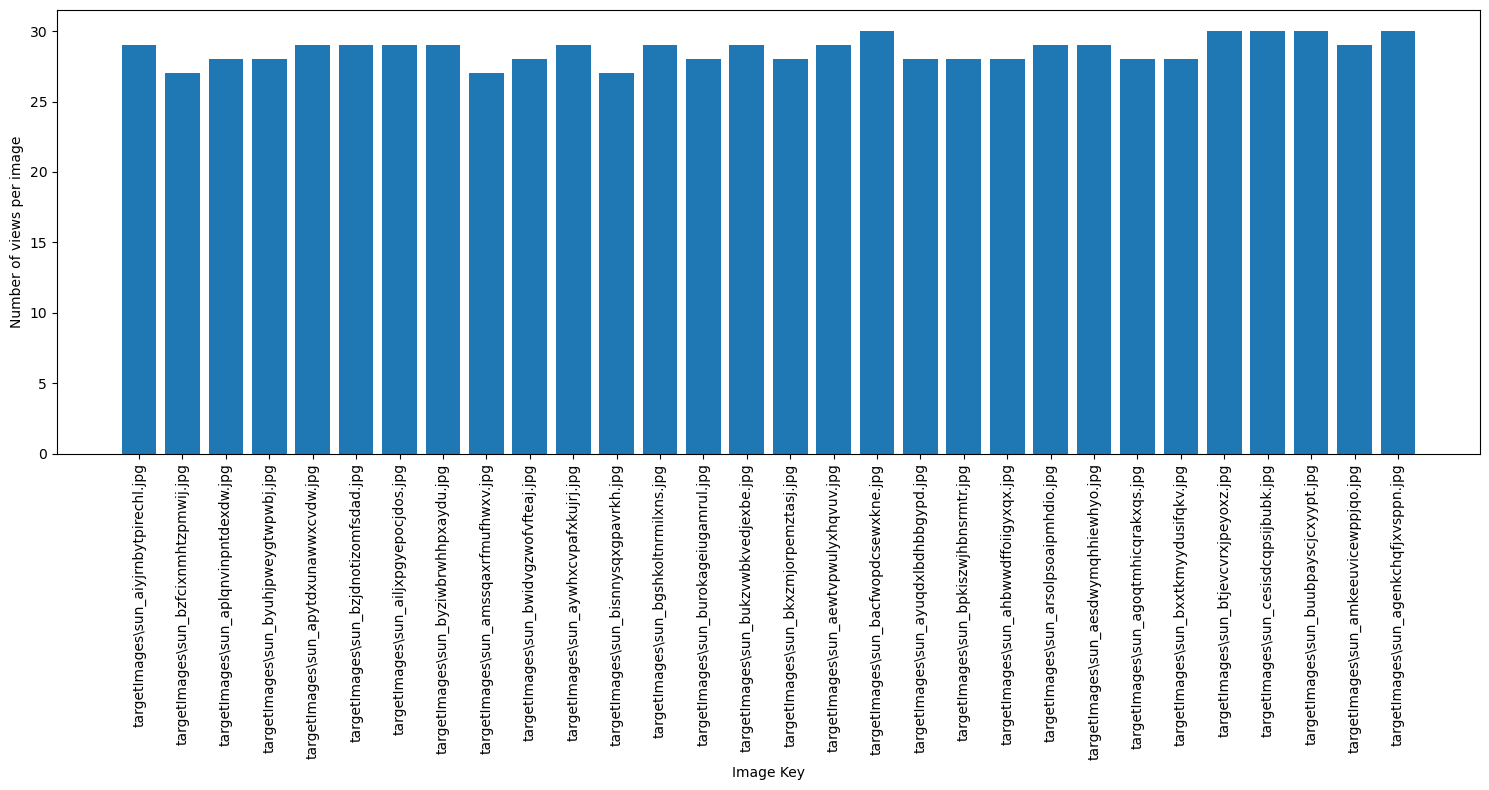

In [5]:
# Extract keys and value
data = stretched_iovcScores
# Extract keys and the second value from the dictionary
keys = list(data.keys())
values = [v[1] for v in data.values()]

# Create a bar plot
plt.figure(figsize=(15, 8))
plt.bar(keys, values)

# Formatting the plot
plt.xlabel('Image Key')
plt.ylabel('Number of views per image')
plt.xticks(rotation=90)
plt.tight_layout()

# Show plot
plt.show()

In [6]:
#same code, but calculates IOVC only from second viewing

import pandas as pd
import cv2
import numpy as np
import os
from scipy.ndimage import gaussian_filter
import math
from collections import Counter
import matplotlib.pyplot as plt
import re

def compute_ppda(distance, h_res, v_res, screen_w, screen_h):
    """
    Compute the number of pixels per degree of visual angle based on the experimental conditions.
    
    :param distance: int, the distance between the observer and the screen (in mm)
    :param h_res: int, the horizontal resolution of the screen
    :param v_res: int, the vertical resolution of the screen
    :param screen_w: int, the width of the screen (in mm)
    :param screen_h: int, the height of the screen (in mm)
    :return horizontal_ppda: float, the number of pixel per degree of visual angle
    """    
    pxl_density_x = h_res / screen_w
    pxl_density_y = v_res / screen_h
    
    d = 2 * distance * math.tan(np.deg2rad(0.5))
    horizontal_ppda = d * ((pxl_density_x + pxl_density_y) / 2)
    
    return horizontal_ppda

# Constants
distance = 610
h_res = 1920
v_res = 1080
screen_w = 527
screen_h = 296

ppda = compute_ppda(distance, h_res, v_res, screen_w, screen_h)
print("ppda", ppda)


def get_current_fixation_map(image_path, coordinates):
    #check if image exists
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image at {image_path} not found.")
        return

    fixation_map = np.zeros((1080, 1920), dtype=np.float32)

    # Convert coordinates to pixel coordinates and update the saliency map
    for x_norm, y_norm in coordinates:
        # Scale normalized coordinates to pixel coordinates for the 1920x1080 screen
        x = int(((x_norm + 1) / 2 ) * 1920)  # Scaling from (-1, 1) to (0, 1920) range
        y = int((y_norm + 0.5) * 1080) # Scaling from (-0.5, 0.5) to (0, 1080) range
        # Update the saliency map if coordinates are within the screen
        if 0 <= x < 1920 and 0 <= y < 1080:
            fixation_map[y, x] += 1 

    # Crop the saliency map to the 700x700 region
    fixation_map = fixation_map[190:890, 610:1310]
    # flip the Y coordinates
    fixation_map = np.flipud(fixation_map)
    return fixation_map

def checkObserverRemembered(observer, image_path, base_dir):
    #print("observer", observer, ", image path", image_path, "base dir ", base_dir)
    # Define the path to the CSV file
    csv_file_path = os.path.join(base_dir, ".." ,"hit_status.csv")
    
    # Check if the file exists
    if not os.path.isfile(csv_file_path):
        print("Error: CSV file not found.")
        return False
    
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)
    
    # Filter rows based on conditions
    filtered_rows = df[(df['Setup Folder'] == observer) & (df['Image Path'] == image_path) & (df['Hit'] == 1)]
    
    # Check if any rows match the conditions
    if not filtered_rows.empty:
        return True
    else:
        return False

# create the output folder
base_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "90experiments"))
output_dir = 'cumulative_saliency_maps'
os.makedirs(output_dir, exist_ok=True)

fixation_maps = {}  # Dictionary to store fixation maps for each imagePath



# Traverse through all folders
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    match = re.search(r'\d{1,2}$', folder)
    if match:
        observer = int(match.group())

    if not os.path.isdir(folder_path):
        continue
 
    if(observer == 1 or observer == 2 or observer == 49 or observer == 5):
        continue

    csv_file_path = os.path.join(folder_path, "eye_tracker_data.csv")
    if not os.path.isfile(csv_file_path):
        continue
    data = pd.read_csv(csv_file_path)

    filtered_data = data[data['ImagePath'].str.startswith('target')]

    firstImagePath = None
    delete_rows = []

    #get only the eye-tracking data from the second viewing
    index = 0
    while index < len(filtered_data):
        row = filtered_data.iloc[index]
        if row['ImagePath'] == firstImagePath:
            break
        if not (firstImagePath is None):
            delete_rows.append(index)  # Append the index instead of the row object
            index += 1
        if row['ImagePath'] and firstImagePath is None:
            firstImagePath = row['ImagePath']
            while filtered_data.iloc[index]['ImagePath'] == firstImagePath:
                delete_rows.append(index)  # Append the index instead of the row object
                index += 1
        

   # Reset the index of the DataFrame
    filtered_data.reset_index(drop=True, inplace=True)

    # Drop the collected rows from the DataFrame
    filtered_data = filtered_data.drop(filtered_data.index[delete_rows]).copy()
    
    grouped = filtered_data.groupby('ImagePath')
    
    # Generate and save fixation maps for each image in the current folder
    for image_path, group in grouped:
        # Construct full image path by going one directory back from base_dir
        full_image_path = os.path.abspath(os.path.join(base_dir, "..", image_path))

        #check if current observer has remembered this image, if not, continue
        if(not checkObserverRemembered(observer, image_path, base_dir)):
            continue
        
        # Extract coordinates
        coordinates = group[['PosX', 'PosY']].values

        output_path = os.path.join(output_dir, os.path.basename(image_path))

        # get current fixation map
        current_fixation_map = get_current_fixation_map (full_image_path, coordinates)
        #add to dictionary or update it
        if image_path not in fixation_maps:
            fixation_maps[image_path] = current_fixation_map
        else:
            fixation_maps[image_path] += current_fixation_map
    


def calculate_value_percentages(sorted_values):
    total_pixels = len(sorted_values)
    value_counts = Counter(sorted_values)
    value_percentages = {value: (count / total_pixels) * 100 for value, count in value_counts.items()}
    return value_percentages

def create_fixation_density_map_25(fixation_map):
    global sumPercentages, numberPercentages
    # Apply Gaussian blur to the saliency map
    sigma = ppda / np.sqrt(2)  # Calculate sigma based on PPDA
    saliency_map = gaussian_filter(fixation_map, sigma=sigma)
    '''
    saliency_map = cv2.GaussianBlur(fixation_map, (91, 91), 0)'''
    max_count = np.max(saliency_map)
    fixation_map_normalized = (saliency_map / max_count) * 255
    fixation_map_normalized = fixation_map_normalized.astype(np.uint8)

   # Flatten the normalized map and sort it to find the threshold
    flattened = fixation_map_normalized.flatten()
    sorted_values = np.sort(flattened)[::-1]

    #print(sorted_values)

    #print(calculate_value_percentages(sorted_values))

    # Calculate the number of pixels corresponding to 25% of the total area
    total_pixels = flattened.size 

    top_25_percent_pixels = int(total_pixels * 0.25)

   # Binary search for the threshold value
    low, high = 0, 255
    while low <= high:
        mid = (low + high) // 2
        binary_map = (fixation_map_normalized >= mid).astype(np.uint8)
        current_top_pixels = np.sum(binary_map)
        
        if current_top_pixels == top_25_percent_pixels:
            break
        elif current_top_pixels > top_25_percent_pixels:
            low = mid + 1
        else:
            high = mid - 1

    # Ensure the final threshold gives us exactly 25% of the pixels
    binary_map = (fixation_map_normalized >= mid).astype(np.uint8)
    current_top_pixels = np.sum(binary_map)

    if current_top_pixels != top_25_percent_pixels:
        if current_top_pixels > top_25_percent_pixels:
            while current_top_pixels > top_25_percent_pixels:
                mid += 1
                binary_map = (fixation_map_normalized >= mid).astype(np.uint8)
                current_top_pixels = np.sum(binary_map)
        else:
            while current_top_pixels < top_25_percent_pixels:
                mid -= 1
                binary_map = (fixation_map_normalized >= mid).astype(np.uint8)
                current_top_pixels = np.sum(binary_map)
    #print("threshold ",mid)
    binary_map = (fixation_map_normalized >= mid).astype(np.uint8)
    #print("%", np.sum(binary_map) / fixation_map_normalized.flatten().size)
    sumPercentages += np.sum(binary_map) / fixation_map_normalized.flatten().size
    numberPercentages += 1
    return binary_map

def getCurrentIOVCscore(binarized_histomap, current_fixation_map):
    # Convert current_fixation_map to a binary map
    binary_fixation_map = (current_fixation_map != 0).astype(int)
    
    matching_pixels = np.sum((binarized_histomap != 0) & (binarized_histomap == binary_fixation_map))
    number_of_non_zero_pixels = np.sum(binary_fixation_map)
    
    return (matching_pixels * 1.0) / number_of_non_zero_pixels


iovcScores = {} # label: 'imagePath', value: IOVC (broj)

sumPercentages = 0
numberPercentages = 0

for k in fixation_maps.keys():
    iovcScores[k] = [0, 0, 0]

# Traverse through all folders
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    match = re.search(r'\d{1,2}$', folder)
    if match:
        observer = int(match.group())

    if not os.path.isdir(folder_path):
        continue

    if(observer == 1 or observer == 2 or observer == 49 or observer == 5):
        continue

    csv_file_path = os.path.join(folder_path, "eye_tracker_data.csv")
    if not os.path.isfile(csv_file_path):
        continue
    data = pd.read_csv(csv_file_path)
    
    filtered_data = data[data['ImagePath'].str.startswith('target')]

    firstImagePath = None
    delete_rows = []

    #get only the eye-tracking data from the second viewing
    index = 0
    while index < len(filtered_data):
        row = filtered_data.iloc[index]
        if row['ImagePath'] == firstImagePath:
            break
        if not (firstImagePath is None):
            delete_rows.append(index)  # Append the index instead of the row object
            index += 1
        if row['ImagePath'] and firstImagePath is None:
            firstImagePath = row['ImagePath']
            while filtered_data.iloc[index]['ImagePath'] == firstImagePath:
                delete_rows.append(index)  # Append the index instead of the row object
                index += 1
        

   # Reset the index of the DataFrame
    filtered_data.reset_index(drop=True, inplace=True)

    # Drop the collected rows from the DataFrame
    filtered_data = filtered_data.drop(filtered_data.index[delete_rows]).copy()

    grouped = filtered_data.groupby('ImagePath')

    # Generate and save fixation maps for each image in the current folder
    for image_path, group in grouped:
        # Construct full image path by going one directory back from base_dir
        full_image_path = os.path.abspath(os.path.join(base_dir, "..", image_path))

        if(not checkObserverRemembered(observer, image_path, base_dir)):
            continue

        # Extract coordinates
        coordinates = group[['PosX', 'PosY']].values
        
        output_path = os.path.join(output_dir, os.path.basename(image_path))

        # get current fixation map
        current_fixation_map = get_current_fixation_map(full_image_path, coordinates)

        fixation_maps[image_path] -= current_fixation_map

        binarized_histomap = create_fixation_density_map_25(fixation_maps[image_path])

        iovcScores[image_path][2] += getCurrentIOVCscore(binarized_histomap, current_fixation_map)
        iovcScores[image_path][1] += 1
        iovcScores[image_path][0] = ( iovcScores[image_path][2] * 1.0 ) / iovcScores[image_path][1]
        
        fixation_maps[image_path] += current_fixation_map
    
    
print("average percentage", (sumPercentages * 1.0) / numberPercentages)

print("average percentage", (sumPercentages * 1.0) / numberPercentages)


# Sort iovcScores by the first item in value field (index 0)
sorted_iovcScores = dict(sorted(iovcScores.items(), key=lambda x: x[1][0], reverse=True))

# Print the sorted iovcScores
print(sorted_iovcScores)

# Stretch from 0.5 - 1; to 0 - 1
stretched_iovcScores = {k: [(v[0] - 0.8) * 5] + v[1:] for k, v in sorted_iovcScores.items()}

# Print the stretched iovcScores
print(stretched_iovcScores)

list_of_scores = []

for k in iovcScores.keys():
    list_of_scores.append(sorted_iovcScores[k][0])

mean_iovc = np.mean(list_of_scores)
std_iovc = np.std(list_of_scores)

print("List of scores: ", list_of_scores)
print("Mean IOVC:", mean_iovc)
print("Standard Deviation of IOVC:", std_iovc)

list_of_scores = []

for k in iovcScores.keys():
    list_of_scores.append(stretched_iovcScores[k][0])

mean_iovc = np.mean(list_of_scores)
std_iovc = np.std(list_of_scores)

print("List of scores: ", list_of_scores)
print("Mean IOVC:", mean_iovc)
print("Standard Deviation of IOVC:", std_iovc)

#write scores to a file
iovc_df = pd.DataFrame.from_dict(stretched_iovcScores, orient='index', columns=['IOVC', 'Count', 'Sum'])

# Keep only the imagePath and IOVC score
iovc_df = iovc_df[['IOVC']]

iovc_df.reset_index(inplace=True)
iovc_df.rename(columns={'index': 'imagePath'}, inplace=True)

csv_output_path = 'sorted_iovc_scores_second_view.csv'
iovc_df.to_csv(csv_output_path, index=False)

ppda 38.81768885920885
average percentage 0.2458885415008436
average percentage 0.2458885415008436
{'targetImages\\sun_bzfcixnmhtzpmwij.jpg': [0.9956345211044052, 24, 23.895228506505724], 'targetImages\\sun_aiyjrnbytpirechl.jpg': [0.9936622554835739, 22, 21.860569620638625], 'targetImages\\sun_bwidvgzwofvfteaj.jpg': [0.9928348110577422, 21, 20.849531032212585], 'targetImages\\sun_bisnnysqxgpavrkh.jpg': [0.992380208003623, 25, 24.809505200090577], 'targetImages\\sun_bzjdnotizomfsdad.jpg': [0.991134231470366, 17, 16.84928193499622], 'targetImages\\sun_ailjxpgyepocjdos.jpg': [0.9875162511437657, 23, 22.712873776306612], 'targetImages\\sun_aewtvpwulyxhqvuv.jpg': [0.9862158970228296, 23, 22.682965631525082], 'targetImages\\sun_apytdxunawwxcvdw.jpg': [0.9851859721425641, 15, 14.777789582138462], 'targetImages\\sun_bkxzmjorpemztasj.jpg': [0.9822035580921415, 20, 19.64407116184283], 'targetImages\\sun_byuhjpweygtwpwbj.jpg': [0.9788246998418085, 20, 19.57649399683617], 'targetImages\\sun_aplqnv

In [7]:
#same code, but calculates IOVC only from successful hits, but only the first viewing

import pandas as pd
import cv2
import numpy as np
import os
from scipy.ndimage import gaussian_filter
import math
from collections import Counter
import matplotlib.pyplot as plt
import re

def compute_ppda(distance, h_res, v_res, screen_w, screen_h):
    """
    Compute the number of pixels per degree of visual angle based on the experimental conditions.
    
    :param distance: int, the distance between the observer and the screen (in mm)
    :param h_res: int, the horizontal resolution of the screen
    :param v_res: int, the vertical resolution of the screen
    :param screen_w: int, the width of the screen (in mm)
    :param screen_h: int, the height of the screen (in mm)
    :return horizontal_ppda: float, the number of pixel per degree of visual angle
    """    
    pxl_density_x = h_res / screen_w
    pxl_density_y = v_res / screen_h
    
    d = 2 * distance * math.tan(np.deg2rad(0.5))
    horizontal_ppda = d * ((pxl_density_x + pxl_density_y) / 2)
    
    return horizontal_ppda

# Constants
distance = 610
h_res = 1920
v_res = 1080
screen_w = 527
screen_h = 296

ppda = compute_ppda(distance, h_res, v_res, screen_w, screen_h)
print("ppda", ppda)


def get_current_fixation_map(image_path, coordinates):
    #check if image exists
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image at {image_path} not found.")
        return

    fixation_map = np.zeros((1080, 1920), dtype=np.float32)

    # Convert coordinates to pixel coordinates and update the saliency map
    for x_norm, y_norm in coordinates:
        # Scale normalized coordinates to pixel coordinates for the 1920x1080 screen
        x = int(((x_norm + 1) / 2 ) * 1920)  # Scaling from (-1, 1) to (0, 1920) range
        y = int((y_norm + 0.5) * 1080) # Scaling from (-0.5, 0.5) to (0, 1080) range
        # Update the saliency map if coordinates are within the screen
        if 0 <= x < 1920 and 0 <= y < 1080:
            fixation_map[y, x] += 1 

    # Crop the saliency map to the 700x700 region
    fixation_map = fixation_map[190:890, 610:1310]
    # flip the Y coordinates
    fixation_map = np.flipud(fixation_map)
    return fixation_map

def checkObserverRemembered(observer, image_path, base_dir):
    #print("observer", observer, ", image path", image_path, "base dir ", base_dir)
    # Define the path to the CSV file
    csv_file_path = os.path.join(base_dir, ".." ,"hit_status.csv")
    
    # Check if the file exists
    if not os.path.isfile(csv_file_path):
        print("Error: CSV file not found.")
        return False
    
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)
    
    # Filter rows based on conditions
    filtered_rows = df[(df['Setup Folder'] == observer) & (df['Image Path'] == image_path) & (df['Hit'] == 1)]
    
    # Check if any rows match the conditions
    if not filtered_rows.empty:
        return True
    else:
        return False

# create the output folder
base_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "90experiments"))
output_dir = 'cumulative_saliency_maps'
os.makedirs(output_dir, exist_ok=True)

fixation_maps = {}  # Dictionary to store fixation maps for each imagePath

# Traverse through all folders
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    match = re.search(r'\d{1,2}$', folder)
    print(folder)
    if match:
        observer = int(match.group())

    if(observer == 1 or observer == 2 or observer == 49 or observer == 5):
        continue

    #if(observer not in [88,89,86,90,18,57,6,45,48,60,63,69,3,9,12,21,15,27,30,33,36,42,24,66,51,54,72,75]):
    #    continue

    if not os.path.isdir(folder_path):
        continue
    csv_file_path = os.path.join(folder_path, "eye_tracker_data.csv")
    if not os.path.isfile(csv_file_path):
        continue

    #print("observer ", observer)
    data = pd.read_csv(csv_file_path)

    filtered_data = data[data['ImagePath'].str.startswith('target')]
    
    uniqueImagePaths = []
    delete_rows = []

    #get only the eye-tracking data from the first viewing
    index = 0
    
    row = filtered_data.iloc[index]
    while len(uniqueImagePaths) < 10:
        row = filtered_data.iloc[index]
        #print("row", row['ImagePath'])
        if(row['ImagePath'] not in uniqueImagePaths):
            uniqueImagePaths.append(row['ImagePath'])
            lastImagePath = row['ImagePath']
            index +=1
        elif(row['ImagePath'] in uniqueImagePaths):
            index += 1    
    row = filtered_data.iloc[index]

    while(row['ImagePath'] == lastImagePath):

        index +=1
        row = filtered_data.iloc[index]

   # Reset the index of the DataFrame
    filtered_data.reset_index(drop=True, inplace=True)

    # Drop the collected rows from the DataFrame
    filtered_data = filtered_data.iloc[:index].copy()

    grouped = filtered_data.groupby('ImagePath')
    
    # Generate and save fixation maps for each image in the current folder
    for image_path, group in grouped:

        # Construct full image path by going one directory back from base_dir
        full_image_path = os.path.abspath(os.path.join(base_dir, "..", image_path))

        #check if current observer remembered this image, if not, continue (i only want images that have successfully been remembered)
        if(not checkObserverRemembered(observer, image_path, base_dir)):
            continue

        # Extract coordinates
        coordinates = group[['PosX', 'PosY']].values

        output_path = os.path.join(output_dir, os.path.basename(image_path))

        # get current fixation map
        current_fixation_map = get_current_fixation_map (full_image_path, coordinates)

        #add to dictionary or update it
        if image_path not in fixation_maps:
            fixation_maps[image_path] = current_fixation_map
        else:
            fixation_maps[image_path] += current_fixation_map
    


def calculate_value_percentages(sorted_values):
    total_pixels = len(sorted_values)
    value_counts = Counter(sorted_values)
    value_percentages = {value: (count / total_pixels) * 100 for value, count in value_counts.items()}
    return value_percentages

def create_fixation_density_map_25(fixation_map, observer, image_path):
    #global variables that store cumulative IOVC and IOVC count
    global sumPercentages, numberPercentages
    
    #BETTER to use bigger blur (first gaus), because there might not be enough pixels to cover 25% with other method
    # Apply Gaussian blur to the saliency map
    sigma = ppda / np.sqrt(2)  # Calculate sigma based on PPDA
    saliency_map = gaussian_filter(fixation_map, sigma=sigma)
    
    #saliency_map = cv2.GaussianBlur(fixation_map, (91, 91), 0)

    max_count = np.max(saliency_map)
    if(max_count == 0):
        print("no white pixels for ", observer, ", image ",image_path)
    fixation_map_normalized = (saliency_map / max_count) * 255
    fixation_map_normalized = fixation_map_normalized.astype(np.uint8)

   # Flatten the normalized map and sort it to find the threshold
    flattened = fixation_map_normalized.flatten()
    #sorted_values = np.sort(flattened)[::-1]

    #print(sorted_values)

    #print(calculate_value_percentages(sorted_values))

    # Calculate the number of pixels corresponding to 25% of the total area
    total_pixels = flattened.size 
    # SUMMARY: find a threshold for which the values greater than it cover 25% of the image area, and return the binary map 
    top_25_percent_pixels = int(total_pixels * 0.1)

   # Binary search for the threshold value
    low, high = 0, 255
    while low <= high:
        mid = (low + high) // 2
        binary_map = (fixation_map_normalized >= mid).astype(np.uint8)
        current_top_pixels = np.sum(binary_map)
        
        if current_top_pixels == top_25_percent_pixels:
            break
        elif current_top_pixels > top_25_percent_pixels:
            low = mid + 1
        else:
            high = mid - 1

    # Ensure the final threshold gives us exactly 25% of the pixels
    binary_map = (fixation_map_normalized >= mid).astype(np.uint8)
    current_top_pixels = np.sum(binary_map)

    if current_top_pixels != top_25_percent_pixels:
        if current_top_pixels > top_25_percent_pixels:
            while current_top_pixels > top_25_percent_pixels:
                mid += 1
                binary_map = (fixation_map_normalized >= mid).astype(np.uint8)
                current_top_pixels = np.sum(binary_map)
        else:
            while current_top_pixels < top_25_percent_pixels:
                mid -= 1
                binary_map = (fixation_map_normalized >= mid).astype(np.uint8)
                current_top_pixels = np.sum(binary_map)
    #print("threshold ",mid)
    binary_map = (fixation_map_normalized >= mid).astype(np.uint8)
    #print("%", np.sum(binary_map) / fixation_map_normalized.flatten().size)
    sumPercentages += np.sum(binary_map) / fixation_map_normalized.flatten().size
    numberPercentages += 1
    return binary_map

def getCurrentIOVCscore(binarized_histomap, current_fixation_map):
    # Convert current_fixation_map to a binary map
    binary_fixation_map = (current_fixation_map != 0).astype(int)
    
    matching_pixels = np.sum((binarized_histomap != 0) & (binarized_histomap == binary_fixation_map))
    number_of_non_zero_pixels = np.sum(binary_fixation_map)
    
    return (matching_pixels * 1.0) / number_of_non_zero_pixels

iovcScores = {} # label: 'imagePath', value: IOVC (broj)

sumPercentages = 0
numberPercentages = 0

for k in fixation_maps.keys():
    iovcScores[k] = [0, 0, 0]

# Traverse through all folders
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    match = re.search(r'\d{1,2}$', folder)
    if match:
        observer = int(match.group())

    if not os.path.isdir(folder_path):
        continue
    if(observer == 1 or observer == 2 or observer == 49 or observer == 5):
        continue

    csv_file_path = os.path.join(folder_path, "eye_tracker_data.csv")
    if not os.path.isfile(csv_file_path):
        continue
    data = pd.read_csv(csv_file_path)

    filtered_data = data[data['ImagePath'].str.startswith('target')]

    uniqueImagePaths = []
    delete_rows = []

    #get only the eye-tracking data from the first viewing
    index = 0
    
    row = filtered_data.iloc[index]
    while len(uniqueImagePaths) < 10:
        row = filtered_data.iloc[index]
        if(row['ImagePath'] not in uniqueImagePaths):
            uniqueImagePaths.append(row['ImagePath'])
            lastImagePath = row['ImagePath']
            index +=1
        elif(row['ImagePath'] in uniqueImagePaths):
            index += 1    
    row = filtered_data.iloc[index]

    while(row['ImagePath'] == lastImagePath):
        index +=1
        row = filtered_data.iloc[index]

    filtered_data.reset_index(drop=True, inplace=True)
    filtered_data = filtered_data.iloc[:index].copy()

    grouped = filtered_data.groupby('ImagePath')
    
    for image_path, group in grouped:
        

        full_image_path = os.path.abspath(os.path.join(base_dir, "..", image_path))

        if(not checkObserverRemembered(observer, image_path, base_dir)):
            continue

        # Extract coordinates
        coordinates = group[['PosX', 'PosY']].values
        
        output_path = os.path.join(output_dir, os.path.basename(image_path))

        # get current fixation map
        current_fixation_map = get_current_fixation_map(full_image_path, coordinates)

        fixation_maps[image_path] -= current_fixation_map
        
        binarized_histomap = create_fixation_density_map_25(fixation_maps[image_path], observer, image_path)

        iovcScores[image_path][2] += getCurrentIOVCscore(binarized_histomap, current_fixation_map)
        iovcScores[image_path][1] += 1
        iovcScores[image_path][0] = ( iovcScores[image_path][2] * 1.0 ) / iovcScores[image_path][1]
        
        fixation_maps[image_path] += current_fixation_map
    
    
print("average percentage", (sumPercentages * 1.0) / numberPercentages)

# Sort iovcScores by the first item in value field (index 0)
sorted_iovcScores = dict(sorted(iovcScores.items(), key=lambda x: x[1][0], reverse=True))

# Print the sorted iovcScores
print(sorted_iovcScores)

# Stretch from 0.5 - 1; to 0 - 1
stretched_iovcScores = {k: [(v[0] - 0.6) * 2.5] + v[1:] for k, v in sorted_iovcScores.items()}

# Print the stretched iovcScores
print(stretched_iovcScores)

list_of_scores = []

for k in iovcScores.keys():
    list_of_scores.append(sorted_iovcScores[k][0])

mean_iovc = np.mean(list_of_scores)
std_iovc = np.std(list_of_scores)

print("List of scores: ", list_of_scores)
print("Mean IOVC:", mean_iovc)
print("Standard Deviation of IOVC:", std_iovc)

list_of_scores = []

for k in iovcScores.keys():
    list_of_scores.append(stretched_iovcScores[k][0])

mean_iovc = np.mean(list_of_scores)
std_iovc = np.std(list_of_scores)

print("List of scores: ", list_of_scores)
print("Mean IOVC:", mean_iovc)
print("Standard Deviation of IOVC:", std_iovc)

#write scores to a file
iovc_df = pd.DataFrame.from_dict(stretched_iovcScores, orient='index', columns=['IOVC', 'Count', 'Sum'])

# Keep only the imagePath and IOVC score
iovc_df = iovc_df[['IOVC']]

iovc_df.reset_index(inplace=True)
iovc_df.rename(columns={'index': 'imagePath'}, inplace=True)

csv_output_path = 'sorted_iovc_scores_first_view.csv'
iovc_df.to_csv(csv_output_path, index=False)
print("finished")


ppda 38.81768885920885
fali.zip
setup1
setup10
setup11
setup12
setup13
setup14
setup15
setup16
setup17
setup18
setup19
setup2
setup20
setup21
setup22
setup23
setup24
setup25
setup26
setup27
setup28
setup29
setup3
setup30
setup31
setup32
setup33
setup34
setup35
setup36
setup37
setup38
setup39
setup4
setup40
setup41
setup42
setup43
setup44
setup45
setup46
setup47
setup48
setup49
setup5
setup50
setup51
setup52
setup53
setup54
setup55
setup56
setup57
setup58
setup59
setup6
setup60
setup61
setup62
setup63
setup64
setup65
setup66
setup67
setup68
setup69
setup7
setup70
setup71
setup72
setup73
setup74
setup75
setup76
setup77
setup78
setup79
setup8
setup80
setup81
setup82
setup83
setup84
setup85
setup86
setup87
setup87.zip
setup88
setup89
setup9
setup90
average percentage 0.10011649821833486
{'targetImages\\sun_aiyjrnbytpirechl.jpg': [0.9592057963069862, 22, 21.102527518753696], 'targetImages\\sun_ailjxpgyepocjdos.jpg': [0.9299495753738644, 22, 20.458890658225016], 'targetImages\\sun_bzfcixnmht

In [9]:
#first view, but with AUC as metric

import pandas as pd
import cv2
import numpy as np
import os
from scipy.ndimage import gaussian_filter
import math
from collections import Counter
import matplotlib.pyplot as plt
import re
from sklearn.metrics import roc_auc_score

def compute_ppda(distance, h_res, v_res, screen_w, screen_h):
    """
    Compute the number of pixels per degree of visual angle based on the experimental conditions.
    
    :param distance: int, the distance between the observer and the screen (in mm)
    :param h_res: int, the horizontal resolution of the screen
    :param v_res: int, the vertical resolution of the screen
    :param screen_w: int, the width of the screen (in mm)
    :param screen_h: int, the height of the screen (in mm)
    :return horizontal_ppda: float, the number of pixel per degree of visual angle
    """    
    pxl_density_x = h_res / screen_w
    pxl_density_y = v_res / screen_h
    
    d = 2 * distance * math.tan(np.deg2rad(0.5))
    horizontal_ppda = d * ((pxl_density_x + pxl_density_y) / 2)
    
    return horizontal_ppda

# Constants
distance = 610
h_res = 1920
v_res = 1080
screen_w = 527
screen_h = 296

ppda = compute_ppda(distance, h_res, v_res, screen_w, screen_h)
print("ppda", ppda)


def get_current_fixation_map(image_path, coordinates):
    #check if image exists
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image at {image_path} not found.")
        return

    fixation_map = np.zeros((1080, 1920), dtype=np.float32)

    # Convert coordinates to pixel coordinates and update the saliency map
    for x_norm, y_norm in coordinates:
        # Scale normalized coordinates to pixel coordinates for the 1920x1080 screen
        x = int(((x_norm + 1) / 2 ) * 1920)  # Scaling from (-1, 1) to (0, 1920) range
        y = int((y_norm + 0.5) * 1080) # Scaling from (-0.5, 0.5) to (0, 1080) range
        # Update the saliency map if coordinates are within the screen
        if 0 <= x < 1920 and 0 <= y < 1080:
            fixation_map[y, x] += 1 

    # Crop the saliency map to the 700x700 region
    fixation_map = fixation_map[190:890, 610:1310]
    # flip the Y coordinates
    fixation_map = np.flipud(fixation_map)
    return fixation_map

def checkObserverRemembered(observer, image_path, base_dir):
    #print("observer", observer, ", image path", image_path, "base dir ", base_dir)
    # Define the path to the CSV file
    csv_file_path = os.path.join(base_dir, ".." ,"hit_status.csv")
    
    # Check if the file exists
    if not os.path.isfile(csv_file_path):
        print("Error: CSV file not found.")
        return False
    
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)
    
    # Filter rows based on conditions
    filtered_rows = df[(df['Setup Folder'] == observer) & (df['Image Path'] == image_path) & (df['Hit'] == 1)]
    
    # Check if any rows match the conditions
    if not filtered_rows.empty:
        return True
    else:
        return False

# create the output folder
base_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "90experiments"))
output_dir = 'cumulative_saliency_maps'
os.makedirs(output_dir, exist_ok=True)

fixation_maps = {}  # Dictionary to store fixation maps for each imagePath

# Traverse through all folders
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    match = re.search(r'\d{1,2}$', folder)
    print(folder)
    if match:
        observer = int(match.group())

    if(observer == 1 or observer == 2 or observer == 49 or observer == 5):
        continue

    #if(observer not in [88,89,86,90,18,57,6,45,48,60,63,69,3,9,12,21,15,27,30,33,36,42,24,66,51,54,72,75]):
    #    continue

    if not os.path.isdir(folder_path):
        continue
    csv_file_path = os.path.join(folder_path, "eye_tracker_data.csv")
    if not os.path.isfile(csv_file_path):
        continue

    #print("observer ", observer)
    data = pd.read_csv(csv_file_path)

    filtered_data = data[data['ImagePath'].str.startswith('target')]
    
    uniqueImagePaths = []
    delete_rows = []

    #get only the eye-tracking data from the first viewing
    index = 0
    
    row = filtered_data.iloc[index]
    while len(uniqueImagePaths) < 10:
        row = filtered_data.iloc[index]
        #print("row", row['ImagePath'])
        if(row['ImagePath'] not in uniqueImagePaths):
            uniqueImagePaths.append(row['ImagePath'])
            lastImagePath = row['ImagePath']
            index +=1
        elif(row['ImagePath'] in uniqueImagePaths):
            index += 1    
    row = filtered_data.iloc[index]

    while(row['ImagePath'] == lastImagePath):

        index +=1
        row = filtered_data.iloc[index]

   # Reset the index of the DataFrame
    filtered_data.reset_index(drop=True, inplace=True)

    # Drop the collected rows from the DataFrame
    filtered_data = filtered_data.iloc[:index].copy()

    grouped = filtered_data.groupby('ImagePath')
    
    # Generate and save fixation maps for each image in the current folder
    for image_path, group in grouped:

        # Construct full image path by going one directory back from base_dir
        full_image_path = os.path.abspath(os.path.join(base_dir, "..", image_path))

        #check if current observer remembered this image, if not, continue (i only want images that have successfully been remembered)
        if(not checkObserverRemembered(observer, image_path, base_dir)):
            continue

        # Extract coordinates
        coordinates = group[['PosX', 'PosY']].values

        output_path = os.path.join(output_dir, os.path.basename(image_path))

        # get current fixation map
        current_fixation_map = get_current_fixation_map (full_image_path, coordinates)

        #add to dictionary or update it
        if image_path not in fixation_maps:
            fixation_maps[image_path] = current_fixation_map
        else:
            fixation_maps[image_path] += current_fixation_map
    


def calculate_value_percentages(sorted_values):
    total_pixels = len(sorted_values)
    value_counts = Counter(sorted_values)
    value_percentages = {value: (count / total_pixels) * 100 for value, count in value_counts.items()}
    return value_percentages

def create_fixation_density_map_25(fixation_map, observer, image_path):
    #global variables that store cumulative IOVC and IOVC count
    global sumPercentages, numberPercentages
    
    #BETTER to use bigger blur (first gaus), because there might not be enough pixels to cover 25% with other method
    # Apply Gaussian blur to the saliency map
    sigma = ppda / np.sqrt(2)  # Calculate sigma based on PPDA
    saliency_map = gaussian_filter(fixation_map, sigma=sigma)
    
    #saliency_map = cv2.GaussianBlur(fixation_map, (91, 91), 0)

    max_count = np.max(saliency_map)
    if(max_count == 0):
        print("no white pixels for ", observer, ", image ",image_path)
    fixation_map_normalized = (saliency_map / max_count) * 255
    fixation_map_normalized = fixation_map_normalized.astype(np.uint8)

   # Flatten the normalized map and sort it to find the threshold
    flattened = fixation_map_normalized.flatten()
    #sorted_values = np.sort(flattened)[::-1]

    #print(sorted_values)

    #print(calculate_value_percentages(sorted_values))

    # Calculate the number of pixels corresponding to 25% of the total area
    total_pixels = flattened.size 
    # SUMMARY: find a threshold for which the values greater than it cover 25% of the image area, and return the binary map 
    top_25_percent_pixels = int(total_pixels * 0.1)

     # Find the threshold value to get top 25% pixels
    threshold = np.percentile(flattened, 75)

    # Create a map retaining the continuous values of the top 25% pixels
    continuous_map_top_25 = np.where(fixation_map_normalized >= threshold, fixation_map_normalized, 0)

    # Sum and count for global statistics
    sumPercentages += np.sum(continuous_map_top_25 > 0) / fixation_map_normalized.flatten().size
    numberPercentages += 1

    return continuous_map_top_25

def getCurrentIOVCscore(binarized_histomap, current_fixation_map):
    # Convert current_fixation_map to a binary map
    binary_fixation_map = (current_fixation_map != 0).astype(int)
    
    y_true = binary_fixation_map.flatten()
    y_score = binarized_histomap.flatten()

    # Calculate AUC score
    auc_score = roc_auc_score(y_true, y_score)

    return auc_score

iovcScores = {} # label: 'imagePath', value: IOVC (broj)

sumPercentages = 0
numberPercentages = 0

for k in fixation_maps.keys():
    iovcScores[k] = [0, 0, 0]

# Traverse through all folders
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    match = re.search(r'\d{1,2}$', folder)
    if match:
        observer = int(match.group())

    if not os.path.isdir(folder_path):
        continue
    if(observer == 1 or observer == 2 or observer == 49 or observer == 5):
        continue

    csv_file_path = os.path.join(folder_path, "eye_tracker_data.csv")
    if not os.path.isfile(csv_file_path):
        continue
    data = pd.read_csv(csv_file_path)

    filtered_data = data[data['ImagePath'].str.startswith('target')]

    uniqueImagePaths = []
    delete_rows = []

    #get only the eye-tracking data from the first viewing
    index = 0
    
    row = filtered_data.iloc[index]
    while len(uniqueImagePaths) < 10:
        row = filtered_data.iloc[index]
        if(row['ImagePath'] not in uniqueImagePaths):
            uniqueImagePaths.append(row['ImagePath'])
            lastImagePath = row['ImagePath']
            index +=1
        elif(row['ImagePath'] in uniqueImagePaths):
            index += 1    
    row = filtered_data.iloc[index]

    while(row['ImagePath'] == lastImagePath):
        index +=1
        row = filtered_data.iloc[index]

    filtered_data.reset_index(drop=True, inplace=True)
    filtered_data = filtered_data.iloc[:index].copy()

    grouped = filtered_data.groupby('ImagePath')
    
    for image_path, group in grouped:
        

        full_image_path = os.path.abspath(os.path.join(base_dir, "..", image_path))

        if(not checkObserverRemembered(observer, image_path, base_dir)):
            continue

        # Extract coordinates
        coordinates = group[['PosX', 'PosY']].values
        
        output_path = os.path.join(output_dir, os.path.basename(image_path))

        # get current fixation map
        current_fixation_map = get_current_fixation_map(full_image_path, coordinates)

        fixation_maps[image_path] -= current_fixation_map
        
        binarized_histomap = create_fixation_density_map_25(fixation_maps[image_path], observer, image_path)

        iovcScores[image_path][2] += getCurrentIOVCscore(binarized_histomap, current_fixation_map)
        iovcScores[image_path][1] += 1
        iovcScores[image_path][0] = ( iovcScores[image_path][2] * 1.0 ) / iovcScores[image_path][1]
        
        fixation_maps[image_path] += current_fixation_map
    
    
print("average percentage", (sumPercentages * 1.0) / numberPercentages)

# Sort iovcScores by the first item in value field (index 0)
sorted_iovcScores = dict(sorted(iovcScores.items(), key=lambda x: x[1][0], reverse=True))

# Print the sorted iovcScores
print(sorted_iovcScores)

# Stretch from 0.5 - 1; to 0 - 1
stretched_iovcScores = {k: [(v[0] - 0.8) * 5] + v[1:] for k, v in sorted_iovcScores.items()}

# Print the stretched iovcScores
print(stretched_iovcScores)

list_of_scores = []

for k in iovcScores.keys():
    list_of_scores.append(sorted_iovcScores[k][0])

mean_iovc = np.mean(list_of_scores)
std_iovc = np.std(list_of_scores)

print("List of scores: ", list_of_scores)
print("Mean IOVC:", mean_iovc)
print("Standard Deviation of IOVC:", std_iovc)

list_of_scores = []

for k in iovcScores.keys():
    list_of_scores.append(stretched_iovcScores[k][0])

mean_iovc = np.mean(list_of_scores)
std_iovc = np.std(list_of_scores)

print("List of scores: ", list_of_scores)
print("Mean IOVC:", mean_iovc)
print("Standard Deviation of IOVC:", std_iovc)

#write scores to a file
iovc_df = pd.DataFrame.from_dict(stretched_iovcScores, orient='index', columns=['IOVC', 'Count', 'Sum'])

# Keep only the imagePath and IOVC score
iovc_df = iovc_df[['IOVC']]

iovc_df.reset_index(inplace=True)
iovc_df.rename(columns={'index': 'imagePath'}, inplace=True)

csv_output_path = 'sorted_iovc_scores_first_view_AUC.csv'
iovc_df.to_csv(csv_output_path, index=False)
print("finished")


ppda 38.81768885920885
fali.zip
setup1
setup10
setup11
setup12
setup13
setup14
setup15
setup16
setup17
setup18
setup19
setup2
setup20
setup21
setup22
setup23
setup24
setup25
setup26
setup27
setup28
setup29
setup3
setup30
setup31
setup32
setup33
setup34
setup35
setup36
setup37
setup38
setup39
setup4
setup40
setup41
setup42
setup43
setup44
setup45
setup46
setup47
setup48
setup49
setup5
setup50
setup51
setup52
setup53
setup54
setup55
setup56
setup57
setup58
setup59
setup6
setup60
setup61
setup62
setup63
setup64
setup65
setup66
setup67
setup68
setup69
setup7
setup70
setup71
setup72
setup73
setup74
setup75
setup76
setup77
setup78
setup79
setup8
setup80
setup81
setup82
setup83
setup84
setup85
setup86
setup87
setup87.zip
setup88
setup89
setup9
setup90
average percentage 0.2599118075801748
{'targetImages\\sun_aiyjrnbytpirechl.jpg': [0.975065806325683, 22, 21.451447739165026], 'targetImages\\sun_ailjxpgyepocjdos.jpg': [0.9691598425032175, 22, 21.321516535070785], 'targetImages\\sun_bzfcixnmhtzp

In [10]:
#in one file, Memorability and IOVC of an image

import pandas as pd

# Load the CSV files into DataFrames
hit_rate_scores = pd.read_csv('hit_rate_scores.csv')
sorted_iovc_scores = pd.read_csv('sorted_iovc_scores_first_view.csv')

# Merge the DataFrames on the specified columns
merged_df = pd.merge(hit_rate_scores, sorted_iovc_scores, left_on='Image', right_on='imagePath')

# Select only the desired columns
final_df = merged_df[['Image', 'Hit Rate', 'IOVC']]

# Save the final DataFrame to a new CSV file
final_df.to_csv('final_merged_scores.csv', index=False)

print("Merge completed and saved to 'final_merged_scores.csv'")


Merge completed and saved to 'final_merged_scores.csv'


In [34]:
import math

# Parameters
accuracy = 0.92
sample_size = 5
confidence_level = 0.95
Z = 1.96  # Z-value for 95% confidence

# Calculate margin of error
margin_of_error = Z * math.sqrt((accuracy * (1 - accuracy)) / sample_size)

# Calculate confidence interval
lower_bound = accuracy - margin_of_error
upper_bound = accuracy + margin_of_error

print(f"Estimated Accuracy with {sample_size} images:")
print(f"Confidence Interval: ({lower_bound:.2f}, {upper_bound:.2f})")


Estimated Accuracy with 5 images:
Confidence Interval: (0.68, 1.16)
